In [2]:
from io import BytesIO
import os
import pickle
from collections import defaultdict

import numpy as np


def load_embeddings(fast_path_dir, seg_embeddings_dir):
    print('Running get embeddings call')
    if fast_path_dir and os.path.exists(fast_path_dir):
        with open(fast_path_dir, 'rb') as f:
            embed_dict = pickle.load(f)

        print('Fast path')
        embeddings = embed_dict['average_embeddings']
        segment_ids_across_images = embed_dict['segment_ids']
        return embeddings, segment_ids_across_images

    print('No fast path sir')
    average_embeddings_across_images = []
    segment_ids_across_images = [] 
    # img_idx = []
    imgs = sorted(os.listdir(seg_embeddings_dir))
    img_to_vec_list = {}
    vector_idx = 0
    vec_to_img = [] # Maps vector index to image index

    print(len(imgs))

    for idx, seg_emb in enumerate(imgs):
        seg_emb_file = os.path.join(seg_embeddings_dir, seg_emb)

        try:
            with open(seg_emb_file, "rb") as f:
                dictionary = pickle.load(f)
        except:
            print('Error loading embeddings', seg_emb)
            continue
    
        dictionary["average_embeddings"] = np.load(BytesIO(dictionary["average_embeddings"]))['a']
        average_embeddings = dictionary["average_embeddings"]
        segment_ids = dictionary["segment_ids"]
        if len(segment_ids) == 0:
            print('what')
            continue

        if segment_ids[0] == 0:
            average_embeddings = average_embeddings[1:]
            segment_ids = segment_ids[1:]

        if len(average_embeddings) == 0:
            continue

        # Have a dictionary of image names pointing to the start and end index of the embeddings
        img_name = seg_emb.split('.pkl')[0]
        start_idx = vector_idx
        # end_idx = start_idx + len(average_embeddings) - 1
        end_idx = start_idx + len(average_embeddings)

        segment_id_idx = len(segment_ids_across_images)
        img_to_vec_list[img_name] = (start_idx, end_idx, segment_id_idx)
        for i in range(start_idx, end_idx):
            # vec_to_img.append(idx)
            vec_to_img.append(img_name)

        average_embeddings_across_images.append(average_embeddings)
        segment_ids_across_images.append(segment_ids)

        vector_idx += len(average_embeddings)
        # img_idx.append(idx)


    average_embeddings_across_images = np.vstack(average_embeddings_across_images)
    
    return average_embeddings_across_images, segment_ids_across_images, img_to_vec_list, vec_to_img

def create_new_pickle(seg_embed_dir, pickle_out_path='coco-2014-val-clip-embeds-fast-2.pkl'):
    if os.path.exists(pickle_out_path):
        print('fast pickle exists loading...')
        with open(pickle_out_path, 'rb') as f:
            embed_dict = pickle.load(f)

        return embed_dict

    embeds, seg_ids, img_to_vec_list, vec_to_img = load_embeddings(None, seg_embed_dir)
    out_dict = {
        'average_embeddings': embeds, 
        'segment_ids': seg_ids, 
        'img_to_vec_list': img_to_vec_list,
        'vec_to_img': vec_to_img,
    }
    with open(pickle_out_path, "wb") as f:
        pickle.dump(out_dict, f)

    return out_dict

# img_dir = '/data/users/jie/data-slicing/COCO/train2017/'
# seg_dir = '/data/users/jie/data-slicing/COCO/sam/train2017_vit_l/'
# embed_dir = '/data/users/jie/data-slicing/COCO/embeds/train2017_fixed_clip_only'
# new_pickle_path = 'train_2017_fixed_clip_only.pkl'

# BDD100K
# img_dir = '/data/users/jie/data-slicing/bdd100k/images/100k/train/'
# seg_dir = '/data/users/jie/data-slicing/bdd100k/sam/vit_l/'
# embed_dir = '/data/users/jie/data-slicing/bdd100k/embeds/sam_maskclip/'
# new_pickle_path = 'bdd100k_sam_maskclip.pkl'

# img_dir = '/data/users/jie/data-slicing/LVIS/train2017'
# seg_dir = '/data/users/jie/data-slicing/LVIS/segmentation'
# embed_dir = '/data/users/jie/data-slicing/LVIS/embeds/train2017_maskclip/'
# new_pickle_path = 'lvis_train2017_maskclip.pkl'

img_dir = '/data/users/jie/data-slicing/COCO/train2017/'
seg_dir = '/data/users/jie/data-slicing/COCO/sam/train2017_vit_l/'
embed_dir = '/data/users/jie/data-slicing/COCO/embeds/train2017_vitl_fixed_maskclip'
new_pickle_path = 'train_2017_vitl_fixed_maskclip.pkl'
embed_dict = create_new_pickle(embed_dir, new_pickle_path)

fast pickle exists loading...


In [3]:
import random
from tqdm import tqdm
import json

import pycocotools

random.seed(43)

average_embeddings = embed_dict['average_embeddings']
img_to_vec_list = embed_dict['img_to_vec_list']
vec_to_img = embed_dict['vec_to_img']
img_to_vec = embed_dict['img_to_vec_list']
seg_ids = embed_dict['segment_ids']
embeds = average_embeddings


n_imgs = len(img_to_vec)
print("Number of images: ", n_imgs)
imgs = sorted(img_to_vec.keys())
idxs = random.sample(range(len(imgs)), n_imgs)
chosen_imgs = [(i, imgs[i]) for i in idxs]
data = [(i, img, img_to_vec[img]) for (i, img) in chosen_imgs]

def extract_segments(json_file):
    with open(json_file, 'r') as f:
        json_dict = json.load(f)
    segments = [seg['segmentation'] for seg in json_dict]
    decoded_segments = []
    for seg in segments:
        decoded_segments.append(pycocotools.mask.decode(seg))
    return decoded_segments

def load_masks(seg_path: str):
    with open(seg_path, 'r') as f:
        sam_output = json.load(f)
    masks = []
    for segment in sam_output:
        rle = segment['segmentation']
        mask = pycocotools.mask.decode(rle)
        masks.append(mask)
    
    return masks

def get_box(mask):
    rows = np.any(mask > 0, axis=1)
    cols = np.any(mask > 0, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max


counter = 0
size_threshold = 0.005

Number of images:  118287


In [4]:
import os
from PIL import Image
from tqdm.notebook import tqdm
import multiprocessing as mp
import numpy as np
from functools import partial
import imagesize

def process_chunk(chunk, seg_ids, embeds, img_dir, seg_dir, size_threshold):
    results = []
    for (idx, img, vec_info) in chunk:
        start, end, seg_id_idx = vec_info
        seg_id = seg_ids[seg_id_idx]
        seg_emb = embeds[start:end]

        # Fix off-by-one seg_id
        seg_id = [i - 1 for i in seg_id]
        seg_id_to_emb = {i: emb for i, emb in zip(seg_id, seg_emb)}
        seg_file = os.path.join(seg_dir, img + '.json')
        if not os.path.exists(seg_file):
            continue

        decoded_segments = load_masks(seg_file)
        id_segments = list(enumerate(decoded_segments))

        # img_rgb = Image.open(os.path.join(img_dir, img)).convert('RGB')
        img_width, img_height = imagesize.get(os.path.join(img_dir, img))
        
        # img_width, img_height = img_rgb.size
        img_area = img_width * img_height

        for i, (curr_seg_id, segment) in enumerate(id_segments):
            try:
                x_min, y_min, x_max, y_max = get_box(segment)
                box_area = (x_max - x_min) * (y_max - y_min)
                if box_area < img_area * size_threshold:
                    continue

                b_box = (x_min / img_width, y_min / img_height, x_max / img_width, y_max / img_height)
                # b_embed = seg_emb[i]
                b_embed = seg_id_to_emb[curr_seg_id]
                results.append((b_box, b_embed, curr_seg_id, img))
            except Exception as e:
                print('Error processing', img, i)
                print(e)

    return results

def get_box_embed_data_parallel(data, seg_ids, embeds, img_dir, seg_dir, size_threshold=0.005, num_processes=None):
    if num_processes is None:
        num_processes = mp.cpu_count()

    # Split the data into chunks
    chunk_size = len(data) // num_processes
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    # Create a pool of worker processes
    with mp.Pool(num_processes) as pool:
        # Create a partial function with fixed arguments
        process_chunk_partial = partial(
            process_chunk,
            seg_ids=seg_ids,
            embeds=embeds,
            img_dir=img_dir,
            seg_dir=seg_dir,
            size_threshold=size_threshold
        )

        # Use tqdm to show progress
        results = list(tqdm(pool.imap(process_chunk_partial, chunks), total=len(chunks), desc="Processing chunks"))

    # Flatten the results
    flattened_results = [item for sublist in results for item in sublist]

    # Separate the results into individual lists
    boxes, box_embeds, box_seg_ids, box_img = zip(*flattened_results)

    return list(boxes), list(box_embeds), list(box_seg_ids), list(box_img)

# Usage example (to be run in a Jupyter notebook cell):

box_pickle_name = new_pickle_path.split('.pkl')[0] + '_boxes.pkl'
boxes, box_embeds, box_seg_ids, box_img = None, None, None, None

if os.path.exists(box_pickle_name):
    print("Load from file")
    with open(box_pickle_name, 'rb') as f:
        box_data = pickle.load(f)

    boxes = box_data['boxes']
    box_embeds = box_data['embeds']
    box_seg_ids = box_data['seg_ids']
    box_img = box_data['img'] 
    # boxes, box_embeds, box_seg_ids, box_img = box_data
else:
    raise Exception("lets not run this")
    print("Load manual (long ):)")
    boxes, box_embeds, box_seg_ids, box_img = get_box_embed_data_parallel(
        data, seg_ids, embeds, img_dir, seg_dir, num_processes=32
    )

    box_dict = {
        'boxes': boxes,
        'embeds': box_embeds,
        'seg_ids': box_seg_ids,
        'img': box_img
    }

    if not os.path.exists(box_pickle_name):
        with open(box_pickle_name, 'wb') as f:
            pickle.dump(box_dict, f)

Load from file


In [5]:
print(len(boxes), len(box_embeds), len(box_seg_ids), len(box_img))

4729509 4729509 4729509 4729509


In [6]:
import math
import faiss

# k_coarse = 512
k_coarse = 1024
# m = 128
m = 256
cluster_bits = 8
n_probes = 3
dim = box_embeds[0].shape[0]

box_embeds_arr = np.array(box_embeds)

sample_points = int(256*(math.sqrt(len(box_embeds))))
print(f"Sample points: {sample_points}")


sample_indices = np.random.choice(len(box_embeds), sample_points, replace=False)
kmeans = faiss.Kmeans(dim, k_coarse, niter=20, verbose=True)
kmeans.train(box_embeds_arr[sample_indices])
d, ids = kmeans.index.search(box_embeds_arr, 1)

centroids = kmeans.centroids[ids].squeeze()
residuals = box_embeds_arr - centroids
# residuals = box_embeds_arr

pqq = faiss.ProductQuantizer(dim, m, cluster_bits)
pqq.train(residuals)




Sample points: 556734
Sampling a subset of 262144 / 556734 for training
Clustering 262144 points in 512D to 1024 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.38 s
  Iteration 19 (6.08 s, search 5.91 s): objective=48899.7 imbalance=1.163 nsplit=0       


In [7]:
all_images = sorted(embed_dict['img_to_vec_list'])
img_to_idx = {img: i for i, img in enumerate(all_images)}

In [8]:
from bitpacking_2 import NumpyBitpackedDict
from tqdm import tqdm

# packd = NumpyBitpackedDict(initial_size=1024, load_factor=0.7)
packd = {}

box_codes = pqq.compute_codes(residuals)
coarse_lists = []
for i in range(k_coarse):
    coarse_lists.append({
        # 'embeds': [],
        'codes': [],
        'boxes': [],
        'seg_ids': [],
        'img': [],
        'offset': [],
    })

packd_to_idx = {}
for i in tqdm(range(len(box_embeds))):
    coarse_idx = ids[i][0]
    # coarse_lists[coarse_idx]['embeds'].append(box_embeds[i])
    img_idx = img_to_idx[box_img[i]]
    coarse_lists[coarse_idx]['codes'].append(box_codes[i])
    coarse_lists[coarse_idx]['boxes'].append(boxes[i])
    coarse_lists[coarse_idx]['seg_ids'].append(box_seg_ids[i])
    coarse_lists[coarse_idx]['img'].append(box_img[i])
    # packd_to_idx[pack_data(img_idx, coarse_idx)] = i
    if (img_idx, coarse_idx) not in packd:
        packd[img_idx, coarse_idx] = [box_codes[i]]
        coarse_lists[coarse_idx]['offset'].append(0)
    else:
        coarse_lists[coarse_idx]['offset'].append(len(packd[img_idx, coarse_idx]))
        packd[img_idx, coarse_idx].append(box_codes[i])


100%|██████████| 4729509/4729509 [00:13<00:00, 363363.59it/s]


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_query_results(result, queries, img_dir):
    for img in result:
        img_path = os.path.join(img_dir, img)
        img_rgb = Image.open(img_path).convert('RGB')
        
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img_rgb)
        
        # Plot each query box
        for i, query in enumerate(queries):
            x_min, y_min, x_max, y_max = query
            width = x_max - x_min
            height = y_max - y_min
            
            # Convert coordinates to pixel values
            x_min_px = x_min * img_rgb.width
            y_min_px = y_min * img_rgb.height
            width_px = width * img_rgb.width
            height_px = height * img_rgb.height
            
            rect = patches.Rectangle((x_min_px, y_min_px), width_px, height_px, 
                                     linewidth=2, edgecolor=plt.cm.rainbow(i/len(queries)), 
                                     facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min_px, y_min_px, f'Query {i+1}', color=plt.cm.rainbow(i/len(queries)), 
                    fontsize=10, verticalalignment='bottom')
        
        plt.title(f"Result: {img}")
        plt.axis('off')
        plt.show()

In [10]:
import subprocess
import pickle
import os

maskclip_python = '/home/jxu680/miniconda3/envs/maskclip/bin/python3'

def get_text_features(text_list):
    # Create a temporary file to store the output
    temp_output_file = 'temp_clip_features.pkl'
    
    # Prepare the command
    command = [
        maskclip_python,
        'clip_encode.py',
        '--word_list'
    ] + text_list + [
        '--output_path',
        temp_output_file
    ]
    
    # Run the subprocess
    try:
        subprocess.run(command, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error running clip_encode.py: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        return None

    # Load the pickle file
    try:
        with open(temp_output_file, 'rb') as f:
            feature_dict = pickle.load(f)
    except Exception as e:
        print(f"Error loading the output file: {e}")
        return None
    finally:
        # Clean up the temporary file
        if os.path.exists(temp_output_file):
            os.remove(temp_output_file)

    return feature_dict

def get_img_features(img_path):
    if isinstance(img_path, str):
        img_path = [img_path]
    # Create a temporary file to store the output
    temp_output_file = 'temp_clip_features.pkl'
    
    # Prepare the command
    command = [
        maskclip_python,
        'clip_encode_image.py',
        '--img_path',
    ] + img_path + [
        '--output_path',
        temp_output_file
    ]

    
    # Run the subprocess
    try:
        subprocess.run(command, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error running clip_encode.py: {e}")
        print(f"stdout: {e.stdout}")
        print(f"stderr: {e.stderr}")
        return None

    # Load the pickle file
    try:
        with open(temp_output_file, 'rb') as f:
            feature_dict = pickle.load(f)
    except Exception as e:
        print(f"Error loading the output file: {e}")
        return None
    finally:
        # Clean up the temporary file
        if os.path.exists(temp_output_file):
            os.remove(temp_output_file)

    return feature_dict

In [11]:
import rangemap
# from python_prtree import PRTree2D
from python_prtree_jeff import PRTree2D
# import python_prtree_jeff

import numpy as np
def pack_data(img_id, n):
    if img_id < 0 or img_id >= (1 << 22):
        raise ValueError("img_id must be between 0 and 2^22 - 1")
    if n < 0 or n >= (1 << 10):
        raise ValueError("coarse_idx must be between 0 and 2^10 - 1")
    return np.uint32((img_id << 10) | n)

def unpack_data(packed_data):
    img_id = (packed_data >> 10) & 0x3FFFFF  # Changed to 0x3FFFFF (22 bits)
    coarse_idx = packed_data & 0x3FF
    return img_id, coarse_idx

trees = []
packed_to_idx = {}
for concept_idx in range(k_coarse):
    # indices = np.arange(len(coarse_lists[i]['codes']))
    indices = []
    concept_list = coarse_lists[concept_idx]
    offsets = concept_list['offset']

    for j in range(len(concept_list['boxes'])):
        img_idx = img_to_idx[concept_list['img'][j]]
        offset = offsets[j]
        packed_to_idx[concept_idx, pack_data(img_idx, offset)] = j
        indices.append(pack_data(img_idx, offset))

    indices = np.array(indices)
    boxes_arr = np.array(concept_list['boxes']).astype(np.float16)
    tree = PRTree2D(indices, boxes_arr)
    trees.append(tree)


In [24]:
(np.array([0,15, 20,30]).astype(np.float32).nbytes + 4) * 100 / 1024 / 1024

0.0019073486328125

In [16]:
from pympler import asizeof

# print(asizeof.asizeof(trees), asizeof.asizeof(packed_to_idx))


total = 0
for tree in trees:
    total += tree.memory_usage()
print(total / 1024 / 1024 )

# 205520



1037.2600631713867


In [18]:
lower_bound = len(boxes) * 4 * 32 / 8
lower_bound += len(box_img) * 32 / 8
print(lower_bound / 1024 / 1024)

90.20822525024414


In [17]:
1075227992 / 1024 / 1024 

1025.4173202514648

In [14]:
def pickle_size_bytes(obj):
    import pickle
    return len(pickle.dumps(obj))

print(pickle_size_bytes(trees), pickle_size_bytes(packed_to_idx))
    

TypeError: cannot pickle 'python_prtree_jeff.PRTree._PRTree2D' object

In [31]:

def plot_query_results(top_k_imgs, query_boxes, img_dir, img_boxes):
    for img in top_k_imgs:
        img_path = os.path.join(img_dir, img)
        img_rgb = Image.open(img_path).convert('RGB')
        
        fig, ax = plt.subplots(1, figsize=(5, 5))
        ax.imshow(img_rgb)
        
        # Plot query boxes
        for i, query in enumerate(query_boxes):
            x_min, y_min, x_max, y_max = query
            width = x_max - x_min
            height = y_max - y_min
            
            x_min_px = x_min * img_rgb.width
            y_min_px = y_min * img_rgb.height
            width_px = width * img_rgb.width
            height_px = height * img_rgb.height
            
            rect = patches.Rectangle((x_min_px, y_min_px), width_px, height_px, 
                                     linewidth=2, edgecolor='r', 
                                     facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x_min_px, y_min_px, f'Query {i+1}', color='r', 
                    fontsize=10, verticalalignment='bottom')
        
        # Plot detected boxes
        for feature_name, box in img_boxes[img].items():
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            
            x_min_px = x_min * img_rgb.width
            y_min_px = y_min * img_rgb.height
            width_px = width * img_rgb.width
            height_px = height * img_rgb.height
            
            rect = patches.Rectangle((x_min_px, y_min_px), width_px, height_px, 
                                     linewidth=2, edgecolor='g', 
                                     facecolor='none')
            ax.add_patch(rect)
            # ax.text(x_min_px, y_max_px, f'Detected: {feature_name}', color='g', 
                    # fontsize=10, verticalalignment='top')
        
        plt.title(f"Result: {img}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2, ord=2)

def cosine_distance(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    xA = max(x1, x3)
    yA = max(y1, y3)
    xB = min(x2, x4)
    yB = min(y2, y4)
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (x2 - x1) * (y2 - y1)
    box2Area = (x4 - x3) * (y4 - y3)
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def draw_query_boxes(queries):
    plt.figure()
    plt.imshow(np.zeros((100, 100)))
    for i in range(len(queries)):
        query = queries[i]
        x_min, y_min, x_max, y_max = query
        rect = patches.Rectangle((x_min * 100, y_min * 100), (x_max - x_min) * 100, (y_max - y_min) * 100, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    plt.show()


In [33]:
q2 = get_img_features('duck.png')
q2 = {'duck':q2, 'duck2': q2}
current_query = q2

In [38]:
current_query = get_text_features(['a photo of a truck'])

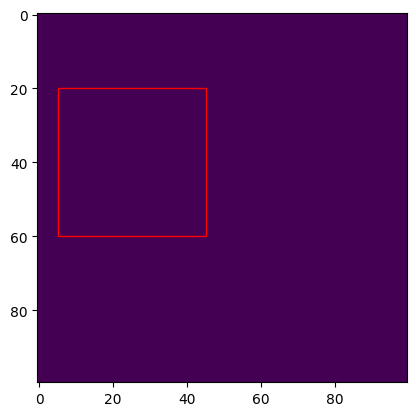

This n candidates 1350


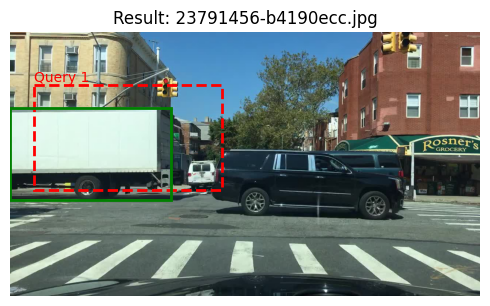

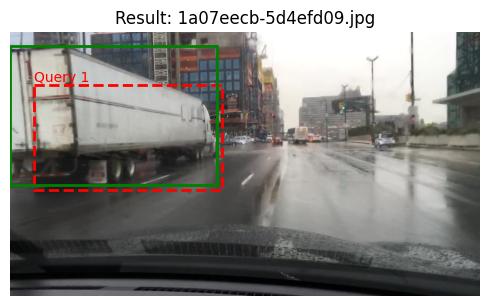

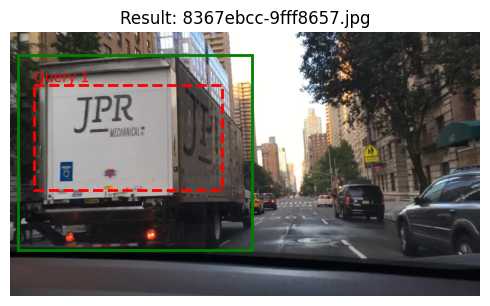

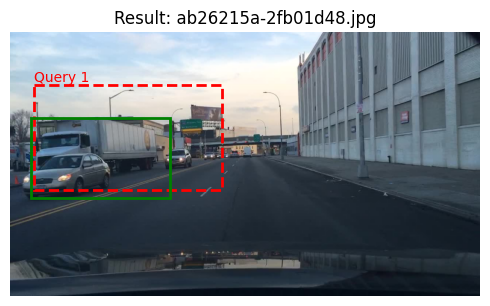

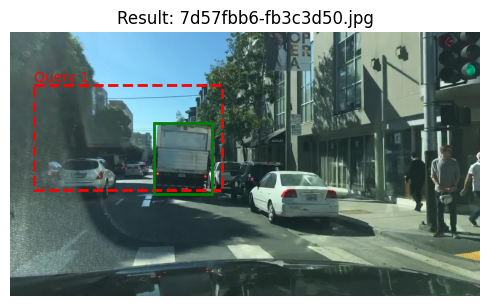

In [77]:
from collections import defaultdict

def unpack_data(packed_data):
    img_id = (packed_data >> 10) & 0x3FFFFF  # Changed to 0x3FFFFF (22 bits)
    coarse_idx = packed_data & 0x3FF
    return img_id, coarse_idx


query_boxes = np.array([
    [0.05, 0.2, 0.45, 0.6],
    # [0.5, 0.2, 1, 0.5]
])

draw_query_boxes(query_boxes)

# q1 = q2
# current_query = q1

nprobes = 1
new_features = defaultdict(lambda: [])
for (box, feature_name) in zip(query_boxes, current_query):
    d, cluster_ids = kmeans.index.search(current_query[feature_name].reshape(1,-1), nprobes)
    centroid_offsets = kmeans.centroids[cluster_ids].squeeze()
    for i in range(nprobes):
        feature_residual = current_query[feature_name] - centroid_offsets[i]
        feature_cluster = cluster_ids[0][i]
        new_features[feature_name].append((feature_cluster, feature_residual, box))

# Will store [img][key] = [PQ, PQ, ...]
img_key = defaultdict(lambda: defaultdict(lambda: []))
img_candidates = defaultdict(lambda: set())
for feature_name, feature_list in new_features.items():
    current_imgs = set()
    for (feature_cluster, feature_residual, box) in feature_list:
        tree_search_idxs = trees[feature_cluster].query(box)
        for idx in tree_search_idxs:
            # try:
                # tree_img = coarse_lists[feature_cluster]['img'][idx]
                # tree_codes = coarse_lists[feature_cluster]['codes'][idx]
                # print('result ', idx)
                tree_img, tree_offset = unpack_data(idx)
                # print('hello', tree_img, tree_offset)
                # print(tree_offset, len(packd[tree_img, feature_cluster]))

                # The set of codes that interact with the current box
                tree_codes = packd[tree_img, feature_cluster][tree_offset]

                idx = packed_to_idx[feature_cluster,idx]
                tree_boxes = coarse_lists[feature_cluster]['boxes'][idx] # Actually just a singular box
                tree_real_img = all_images[tree_img]
                img_key[tree_real_img][feature_name].append((tree_codes, tree_boxes, box, feature_residual)) # TODO: Unideal to duplicate the feature_residual
                current_imgs.add(tree_real_img)
            # except Exception as e:
                # print('Error processing', tree_img, idx)
                # print(e)
                # print(len(coarse_lists[feature_cluster]['img']))

    img_candidates[feature_name] = current_imgs


# Get the intersection of all images
common_imgs = set.intersection(*img_candidates.values())
print('This n candidates', len(common_imgs))
img_distances = defaultdict(lambda: 0)
img_counter = defaultdict(lambda: 0)
img_boxes = defaultdict(lambda: defaultdict(str))
alpha = .95
for img in common_imgs:
    for feature_name in new_features.keys():
        min_distance = 1e9
        min_box = (0, 0, 1, 1)
        # print(img, feature_name, len(img_key[img][feature_name]))
        for (codes, tree_box, box, feature_residual) in img_key[img][feature_name]:
            decoded_residual = pqq.decode(codes.reshape(1, -1))[0].flatten()
            feature_residual = feature_residual.flatten()
            # distance = euclidean_distance(decoded_residual, feature_residual)
            distance = cosine_distance(decoded_residual, feature_residual)
            distance = distance * alpha + (1 - iou(tree_box, box)) * (1 - alpha)
            # print(distance)
            # print('this is tree box bro', tree_box)
            # print('hi')
            if distance < min_distance:
                min_distance = distance * alpha + (1 - iou(tree_box, box)) * (1 - alpha)
                min_box = tree_box

        img_boxes[img][feature_name] = min_box
        img_distances[img] += min_distance
        img_counter[img] += 1

# Plot top k images
k = 5
top_k_imgs = sorted(img_distances, key=img_distances.get)[:k]
# print(img_distances)



plot_query_results(top_k_imgs, query_boxes, img_dir, img_boxes)
